# **Analyzing the Impact of Fire Hydrant Density and Financial Status on Emergency Incidents in Cincinnati: A Data-driven Approach**

![Banner](./assets/banner.jpeg)

## Topic
*What problem are you (or your stakeholder) trying to address?*
📝 <!-- Answer Below -->

    In this data analytics project, the primary goal is to explore and analyze the relationship between fire hydrant distribution, local tax information, and incidents where Emergency Medical Services (EMS) had to respond in the Cincinnati area. The overarching problem we aim to address is understanding the factors that might influence emergency response times or incidents in different localities.

**Potential questions to address could include:**

    Response Time Analysis: Are there correlations between the distribution of fire hydrants and the response times of EMS in different localities? Does the density of fire hydrants affect how quickly EMS can reach incidents?

    Financial Impact: How does the tax information of different localities correlate with the number of incidents or the efficiency of emergency responses? Are areas with higher tax revenues better equipped for emergency situations?

    Incident Patterns: Can we identify any patterns in incidents requiring EMS response based on the proximity to fire hydrants or the financial status of the locality? For instance, are there more incidents in areas with lower tax revenues?

## Project Question
*What specific question are you seeking to answer with this project?*
*This is not the same as the questions you ask to limit the scope of the project.*
📝 <!-- Answer Below -->

    "Is there a correlation between the density of fire hydrants, local tax information (financial status), and the frequency of incidents requiring Emergency Medical Services (EMS) response in different localities within the Cincinnati area?"

## What would an answer look like?
*What is your hypothesized answer to your question?*
📝 <!-- Answer Below -->


    "I believe there may be a correlation suggesting that localities with higher fire hydrant density and greater financial resources (indicated by higher tax revenues) could experience fewer incidents requiring Emergency Medical Services (EMS) response. The rationale behind this hypothesis is that well-funded areas may have better infrastructure, including sufficient fire hydrants, which could contribute to quicker and more effective emergency responses." 

## Data Sources
*What 3 data sources have you identified for this project?*
*How are you going to relate these datasets?*
📝 <!-- Answer Below -->

The first is api from [data.cincinnati-oh.gov](https://data.cincinnati-oh.gov/Thriving-Neighborhoods/Fire-Hydrants-Greater-Cincinnati-Water-Works-/qhw6-ujsg). This dataset contains information regarding the fire hydrants that are located around the city and their various statuses and is available in both .json and .csv format, but I will be opting to use this in .json. 

The second source is a csv file from [data.cincinnati-oh.gov](https://data.cincinnati-oh.gov/Growing-Economic-Opportunities/Tax-Increment-Financing-Districts/jy3n-t8je). **Tax_Increment_Financing_Districts.csv** This information is very useful in that it will provide the different economic insights in the various locations under the greater cincinnati banner. 

The final source is a csv file from [data.cincinnati-oh.gov](https://data.cincinnati-oh.gov/Safety/Cincinnati-Fire-Incidents-CAD-including-EMS-ALS-BL/vnsz-a3wp) **Cincinnati_Fire_Incidents.csv**. This file has information regarding the various incidents where fire and ems vehicles were called to respond to.

The way that these can relate is that I can analyze both the financial status of the location and how many hydrants are available and see how it correlates to the incidents that occur in those areas. since these are all Cincinnati based, they should have location codes that will allow them to be used together pretty easily. In the next segment I will break down my approach further.

## Approach and Analysis
*What is your approach to answering your project question?*
*How will you use the identified data to answer your project question?*
📝 <!-- Start Discussing the project here; you can add as many code cells as you need -->

    To relate the three data sources and arrive at meaningful insights, I will follow a systematic approach:

   1. **Data Cleaning:**
   - Identify and handle missing or inconsistent data.
   - Standardize column names and data types across datasets for ease of merging.

   2. **Merging Datasets:**
   - Merge the datasets based on common fields that can serve as keys as needed. 

   3. **Exploratory Data Analysis (EDA):**
   - Conduct exploratory data analysis to gain insights into the distribution and characteristics of the merged dataset.
   - Use visualizations to highlight patterns, correlations, and outliers.

   4. **Regression Analysis:**
   - Perform regression analysis to model the relationships between variables of interest such as tax information and fire hydrant density.

   5. **Correlation Analysis:**
   - Calculate correlation coefficients to quantify the strength and direction of relationships between variables as needed.

   6. **Data Visualization:**
   - Create visualizations to effectively communicate the findings. This could include geographical maps showing fire hydrant distribution, bar charts illustrating tax information by locality, and scatter plots depicting the relationship between variables.

   7. **Conclusions and Recommendations:**
   - Summarize the key findings and insights derived from the analysis.


       Note that these will not all be performed in this exact order, and that some parts will supplement others. For example, I might use visualizations to help with the EDA. By using this approach the conclusions that can be made will be meaningful and impactful.

In [3]:
# Start your code here
from dotenv import load_dotenv

import os
import csv
import json
import sklearn

import sodapy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sodapy import Socrata

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from urllib.request import urlretrieve
from zipfile import ZipFile
from sqlalchemy import create_engine, text
from pymongo import MongoClient
from sklearn.pipeline import FeatureUnion

import requests
from bs4 import BeautifulSoup

load_dotenv(override=True) 
pd.set_option('display.max_rows', 500)

In [4]:
tax_df = pd.read_csv('Tax_Increment_Financing_Districts.csv')
fire_incidents_df = pd.read_csv('Cincinnati_Fire_Incidents.csv')

In [5]:
load_dotenv()
api_key = os.getenv("APP_TOKEN")

client = Socrata("data.cincinnati-oh.gov", api_key)

dataset_id = "qhw6-ujsg"

params = {
    "limit": 5000,
}

results = client.get(dataset_id, **params)

hydrant_df = pd.DataFrame.from_records(results)

## Exploratory Data Anlysis 

The first part of this stage is that we will view the data and statistical summaries/information regarding it. 

In [6]:
display(fire_incidents_df.describe())
display(tax_df.describe())
display(hydrant_df.describe())

,LATITUDE_X,LONGITUDE_X
count,751765.000000,751765.000000
mean,39.140149,-84.514744
std,0.279162,0.352720
min,-86.998771,-114.997841
25%,39.114039,-84.556881
50%,39.135962,-84.515508
75%,39.159133,-84.485114
max,90.000660,155.639117


,BUDGET_FISCAL_YEAR,FISCAL_YEAR,FUND_CODE,POSTING_AMOUNT,RECORD_NO,TIF_DISTRICT_NO
count,13869.000000,13869.000000,13869.000000,1.386900e+04,1.386900e+04,13869.000000
mean,2019.354315,2019.354315,489.783834,2.526571e-12,2.706993e+07,11.064172
std,2.946363,2.946363,11.640316,1.227138e+06,5.381716e+06,7.547059
min,2015.000000,2015.000000,468.000000,-1.312294e+07,1.788403e+07,1.000000
25%,2017.000000,2017.000000,483.000000,-6.468500e+04,2.224794e+07,4.000000
50%,2019.000000,2019.000000,488.000000,3.000000e-02,2.745628e+07,9.000000
75%,2022.000000,2022.000000,495.000000,6.500000e+04,3.193359e+07,17.000000
max,2024.000000,2024.000000,536.000000,1.312294e+07,3.522541e+07,36.000000


,objectid,assetid,lifecyclestatus,servicearea,staticpressure,latitude,longitude,neighborhood
count,5000,5000,5000,4998,4998,5000,5000,5000
unique,5000,5000,2,16,190,5000,5000,51
top,1,340816,AC,WH,79,39.1362276109435,-84.4455310422017,N/A
freq,1,1,4789,1847,107,1,1,3393


In [7]:
display(fire_incidents_df.info())
display(tax_df.info())
display(hydrant_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775349 entries, 0 to 775348
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ADDRESS_X                       775227 non-null  object 
 1   LATITUDE_X                      751765 non-null  float64
 2   LONGITUDE_X                     751765 non-null  float64
 3   AGENCY                          775349 non-null  object 
 4   CREATE_TIME_INCIDENT            775240 non-null  object 
 5   DISPOSITION_TEXT                769309 non-null  object 
 6   EVENT_NUMBER                    775349 non-null  object 
 7   INCIDENT_TYPE_ID                771080 non-null  object 
 8   INCIDENT_TYPE_DESC              744031 non-null  object 
 9   NEIGHBORHOOD                    749912 non-null  object 
 10  ARRIVAL_TIME_PRIMARY_UNIT       663962 non-null  object 
 11  BEAT                            774745 non-null  object 
 12  CLOSED_TIME_INCI

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13869 entries, 0 to 13868
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   BUDGET_FISCAL_YEAR     13869 non-null  int64  
 1   FISCAL_YEAR            13869 non-null  int64  
 2   FUND_CODE              13869 non-null  int64  
 3   FUND_NAME              13869 non-null  object 
 4   POSTING_CODE_ID        13869 non-null  object 
 5   POSTING_AMOUNT         13869 non-null  float64
 6   POSTING_CODE_NAME      13869 non-null  object 
 7   RECORD_NO              13869 non-null  int64  
 8   DOC_RECORD_DATE        13869 non-null  object 
 9   FUNDS_CLASS_CODE       13869 non-null  object 
 10  OBJECT_CODE            9081 non-null   object 
 11  OBJECT_CODE_NAME       9081 non-null   object 
 12  TIF_DISTRICT_NO        13869 non-null  int64  
 13  TIF_DISTRICT_NAME      13869 non-null  object 
 14  TIF_ORDINANCE          13869 non-null  object 
 15  CO

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   objectid         5000 non-null   object
 1   assetid          5000 non-null   object
 2   lifecyclestatus  5000 non-null   object
 3   servicearea      4998 non-null   object
 4   staticpressure   4998 non-null   object
 5   latitude         5000 non-null   object
 6   longitude        5000 non-null   object
 7   neighborhood     5000 non-null   object
dtypes: object(8)
memory usage: 312.6+ KB


None

## First Impressions
When analyzing the above information that is provided at a first glance, there are some notable issues that should be addressed. 

While the hydrant and incident dataframes have the key "neighborhood" variable that can help them be easily linked, the tax dataframe does not. I can look into identifying the specific key in the tax document to normalize it so that it is consistent with the other dataframes. It is also shown that there are some missing variables and some null/na ones that will need to be either trimmed down or replaced. In this instance I think that it is fine to drop them because each instance and hydrant is unique, so it wouldn't really make sense to try to fill them with averages or anything. Another thing to note is that there are some variables that are not needed like the specific codes for each tax area, so we can go ahead and remove those later so they don't clutter the data/analysis.

## Data Cleaning
As seen above in some of the visualizations and the data summaries, there are instances of missing variables and duplicates that need to be cleaned so the dataset can be used more accurately. There are also a lot of data columns that will not be used in this analysis, so cleaning these up can make it more clear cut. 

In [8]:
valid_cfd_types = ['FIRE', 'OTHE']
fire_incidents_df = fire_incidents_df[fire_incidents_df['CFD_INCIDENT_TYPE'].isin(valid_cfd_types)]

columns_to_drop_fire = ['ADDRESS_X', 'AGENCY',  'DISPOSITION_TEXT', 'INCIDENT_TYPE_ID', 'INCIDENT_TYPE_DESC']
fire_incidents_df = fire_incidents_df.drop(columns=columns_to_drop_fire)

fire_incidents_df = fire_incidents_df.dropna()

In [9]:

fire_incidents_df['ARRIVAL_TIME_PRIMARY_UNIT'] = pd.to_datetime(fire_incidents_df['ARRIVAL_TIME_PRIMARY_UNIT'])
fire_incidents_df['CLOSED_TIME_INCIDENT'] = pd.to_datetime(fire_incidents_df['CLOSED_TIME_INCIDENT'])
fire_incidents_df['DISPATCH_TIME_PRIMARY_UNIT'] = pd.to_datetime(fire_incidents_df['DISPATCH_TIME_PRIMARY_UNIT'])
fire_incidents_df['CREATE_TIME_INCIDENT'] = pd.to_datetime(fire_incidents_df['CREATE_TIME_INCIDENT'])

C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\1678631956.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire_incidents_df['ARRIVAL_TIME_PRIMARY_UNIT'] = pd.to_datetime(fire_incidents_df['ARRIVAL_TIME_PRIMARY_UNIT'])
C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\1678631956.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire_incidents_df['CLOSED_TIME_INCIDENT'] = pd.to_datetime(fire_incidents_df['CLOSED_TIME_INCIDENT'])
C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\1678631956.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire_incidents_df['DISPATCH

In [10]:
fire_incidents_df['response_time'] = (fire_incidents_df['ARRIVAL_TIME_PRIMARY_UNIT'] - fire_incidents_df['DISPATCH_TIME_PRIMARY_UNIT']).dt.total_seconds()

In [11]:
print(fire_incidents_df.info())
print(fire_incidents_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 109055 entries, 1 to 765157
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   LATITUDE_X                      109055 non-null  float64       
 1   LONGITUDE_X                     109055 non-null  float64       
 2   CREATE_TIME_INCIDENT            109055 non-null  datetime64[ns]
 3   EVENT_NUMBER                    109055 non-null  object        
 4   NEIGHBORHOOD                    109055 non-null  object        
 5   ARRIVAL_TIME_PRIMARY_UNIT       109055 non-null  datetime64[ns]
 6   BEAT                            109055 non-null  object        
 7   CLOSED_TIME_INCIDENT            109055 non-null  datetime64[ns]
 8   DISPATCH_TIME_PRIMARY_UNIT      109055 non-null  datetime64[ns]
 9   CFD_INCIDENT_TYPE               109055 non-null  object        
 10  CFD_INCIDENT_TYPE_GROUP         109055 non-null  object      

In [12]:
hydrant_df['latitude'] = pd.to_numeric(hydrant_df['latitude'], errors='coerce')
hydrant_df['longitude'] = pd.to_numeric(hydrant_df['longitude'], errors='coerce')

columns_to_drop_hydrant = ['staticpressure']
hydrant_df = hydrant_df.rename(columns={'neighborhood': 'NEIGHBORHOOD'})
active_hydrants_by_neighborhood = hydrant_df[hydrant_df['lifecyclestatus'] == 'AC'].groupby('NEIGHBORHOOD').size().reset_index(name='active_hydrant_count')
hydrant_df['NEIGHBORHOOD'].replace('N/A', np.nan, inplace=True)
hydrant_df = hydrant_df.drop(columns=columns_to_drop_hydrant)
hydrant_df.dropna()


hydrant_df = pd.merge(hydrant_df, active_hydrants_by_neighborhood, on='NEIGHBORHOOD', how='left')

In [13]:
hydrant_df = hydrant_df[hydrant_df['NEIGHBORHOOD'].notnull()]
print(hydrant_df.info())
print(hydrant_df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 0 to 4991
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   objectid              1607 non-null   object 
 1   assetid               1607 non-null   object 
 2   lifecyclestatus       1607 non-null   object 
 3   servicearea           1607 non-null   object 
 4   latitude              1607 non-null   float64
 5   longitude             1607 non-null   float64
 6   NEIGHBORHOOD          1607 non-null   object 
 7   active_hydrant_count  1607 non-null   float64
dtypes: float64(3), object(5)
memory usage: 113.0+ KB
None
          latitude    longitude  active_hydrant_count
count  1607.000000  1607.000000           1607.000000
mean     39.139924   -84.508578             46.533292
std       0.032568     0.065989             25.938595
min      39.059479   -84.701306              4.000000
25%      39.114814   -84.554887             28.000000
50%   

In [14]:
tax_df['DOC_RECORD_DATE'] = pd.to_datetime(tax_df['DOC_RECORD_DATE'])
tax_df['COUNCIL_DATE'] = pd.to_datetime(tax_df['COUNCIL_DATE'])

columns_to_drop_tax = ['FUND_CODE', 'POSTING_CODE_ID', 'DOC_RECORD_DATE', 'FUNDS_CLASS_CODE', 'OBJECT_CODE', 'OBJECT_CODE_NAME', 'TIF_ORDINANCE', 'COUNCIL_DATE', 'COUNCIL_ORDINANCE_URL']
tax_df = tax_df.drop(columns=columns_to_drop_tax)

tax_df = tax_df.dropna()

tax_df = tax_df.rename(columns={'TIF_DISTRICT_NAME': 'NEIGHBORHOOD'})


C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\909500199.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tax_df['DOC_RECORD_DATE'] = pd.to_datetime(tax_df['DOC_RECORD_DATE'])
C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\909500199.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tax_df['COUNCIL_DATE'] = pd.to_datetime(tax_df['COUNCIL_DATE'])


In [15]:
print(tax_df.info())
print(tax_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13869 entries, 0 to 13868
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BUDGET_FISCAL_YEAR  13869 non-null  int64  
 1   FISCAL_YEAR         13869 non-null  int64  
 2   FUND_NAME           13869 non-null  object 
 3   POSTING_AMOUNT      13869 non-null  float64
 4   POSTING_CODE_NAME   13869 non-null  object 
 5   RECORD_NO           13869 non-null  int64  
 6   TIF_DISTRICT_NO     13869 non-null  int64  
 7   NEIGHBORHOOD        13869 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 866.9+ KB
None
       BUDGET_FISCAL_YEAR   FISCAL_YEAR  POSTING_AMOUNT     RECORD_NO  \
count        13869.000000  13869.000000    1.386900e+04  1.386900e+04   
mean          2019.354315   2019.354315    2.526571e-12  2.706993e+07   
std              2.946363      2.946363    1.227138e+06  5.381716e+06   
min           2015.000000   2015.000000  

## Explanation of Cleaning

So my rationale here was to isolate events to only Fire and "other" (this came from the website as it had the data dictionary which said that fire and othe were the codes for fire responses) since we are only looking at fire responses in this particular analysis and not every ems response. I made sure to drop all of the irrelevant data columns as the datasets were larger and took a long time to load so this helped expedite that process. I also made sure to drop any null/na values as this particular analysis it would not feel appropraite to replace them with some other statistical value as each incident is unique to its event. I also renamed the 'TIF_DISTRICT_NAME' column to 'Neighborhood' for consistency sake and to make it easier to merge the data later. 

## Visualizations

Below will be some visualizations I used to explore the data, and further down below them will have a write up of things that I observed.

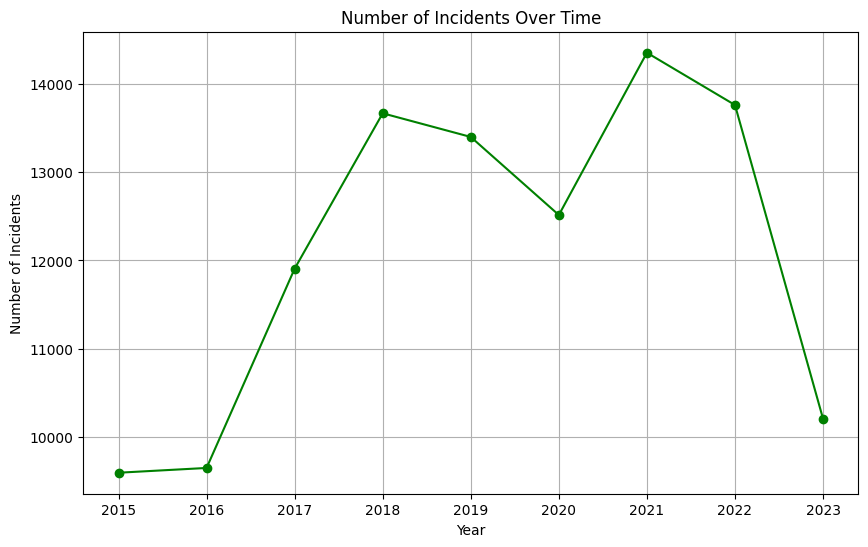

In [16]:
fire_incidents_df['Year'] = fire_incidents_df['CREATE_TIME_INCIDENT'].dt.year

incidents_per_year = fire_incidents_df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.plot(incidents_per_year.index, incidents_per_year.values, marker='o', color='green')
plt.title('Number of Incidents Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


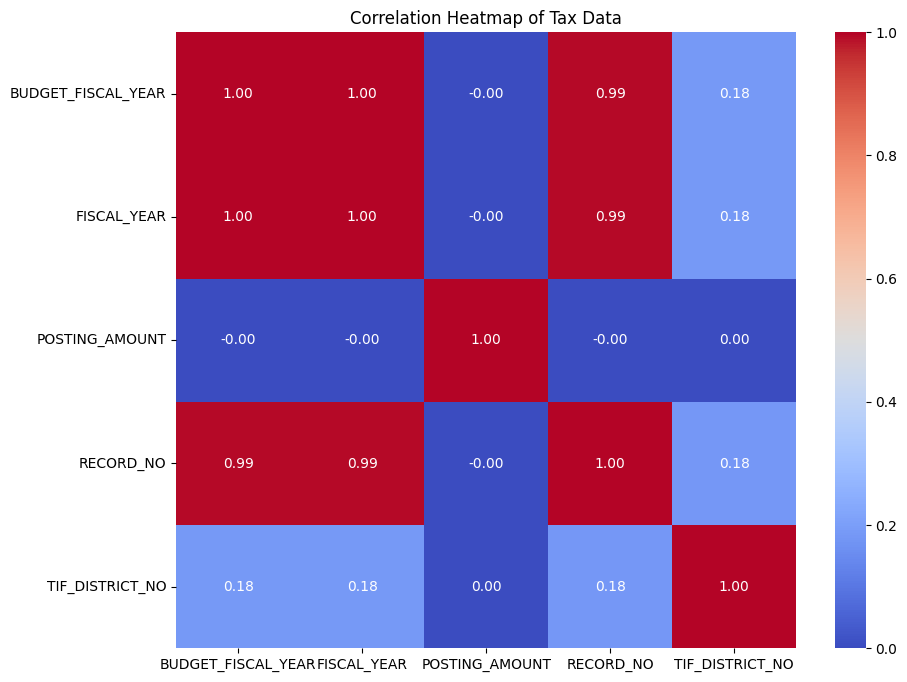

In [17]:
numerical_columns_tax = tax_df.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix_tax = tax_df[numerical_columns_tax].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_tax, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Tax Data')
plt.show()


<Figure size 1200x800 with 0 Axes>

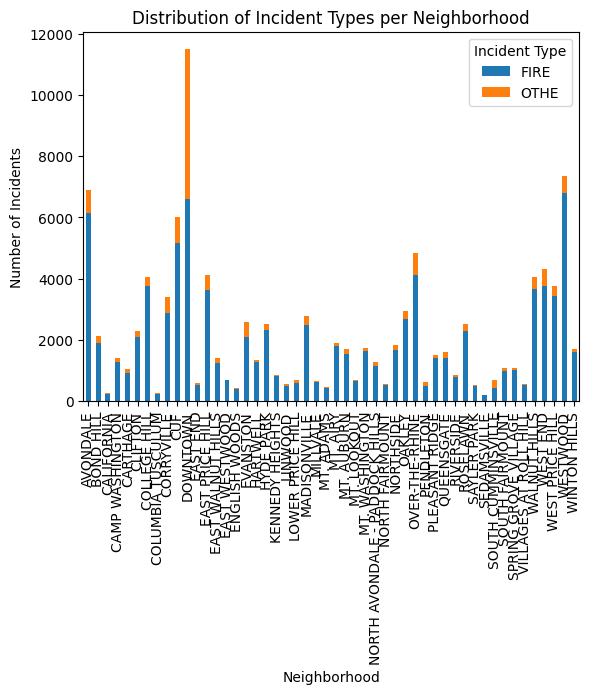

In [18]:
neighborhood_incident_counts = fire_incidents_df.groupby(['NEIGHBORHOOD', 'CFD_INCIDENT_TYPE']).size().unstack()

plt.figure(figsize=(12, 8))
neighborhood_incident_counts.plot(kind='bar', stacked=True,)
plt.title('Distribution of Incident Types per Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Incidents')
plt.legend(title='Incident Type', bbox_to_anchor=(1, 1))
plt.show()


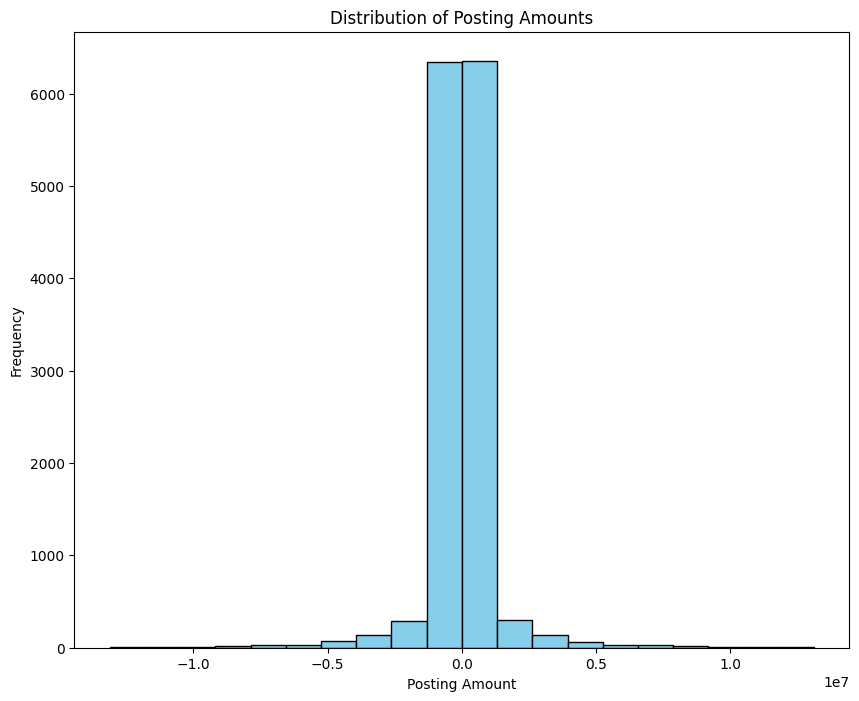

In [19]:
plt.figure(figsize=(10, 8))
plt.hist(tax_df['POSTING_AMOUNT'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Posting Amounts')
plt.xlabel('Posting Amount')
plt.ylabel('Frequency')
plt.show()

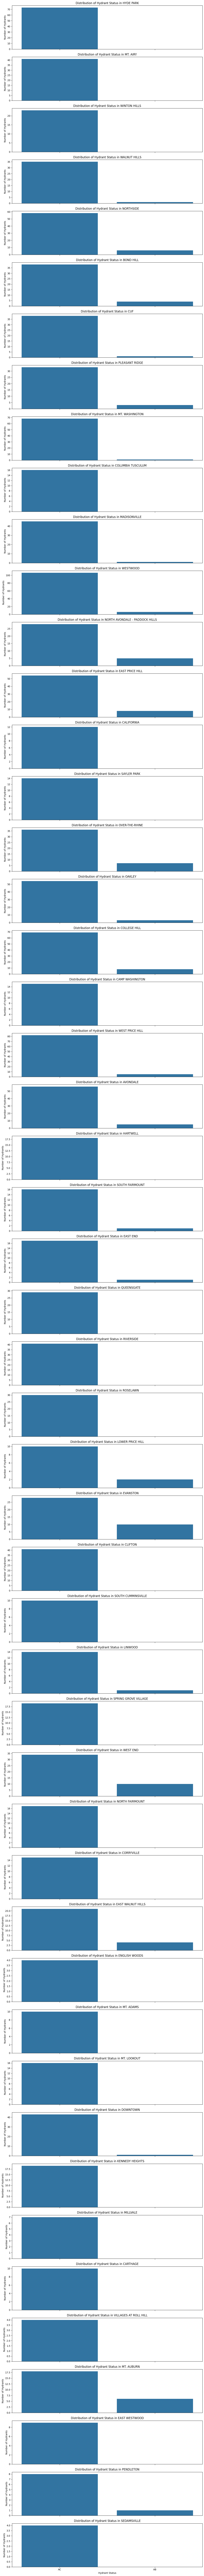

In [20]:
neighborhoods = hydrant_df['NEIGHBORHOOD'].unique()

fig, axes = plt.subplots(nrows=len(neighborhoods), figsize=(12, 3 * len(neighborhoods)), sharex=True)

for i, neighborhood in enumerate(neighborhoods):
    neighborhood_data = hydrant_df[hydrant_df['NEIGHBORHOOD'] == neighborhood]
    neighborhood_status_counts = neighborhood_data['lifecyclestatus'].value_counts()
    
    sns.barplot(x=neighborhood_status_counts.index, y=neighborhood_status_counts.values, ax=axes[i])
    axes[i].set_title(f'Distribution of Hydrant Status in {neighborhood}')
    axes[i].set_xlabel('Hydrant Status')
    axes[i].set_ylabel('Number of Hydrants')

plt.tight_layout()
plt.show()

C:\Users\lognc\AppData\Local\Temp\ipykernel_14672\948341098.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='POSTING_AMOUNT', y='NEIGHBORHOOD', data=neighborhood_spending, palette='viridis')


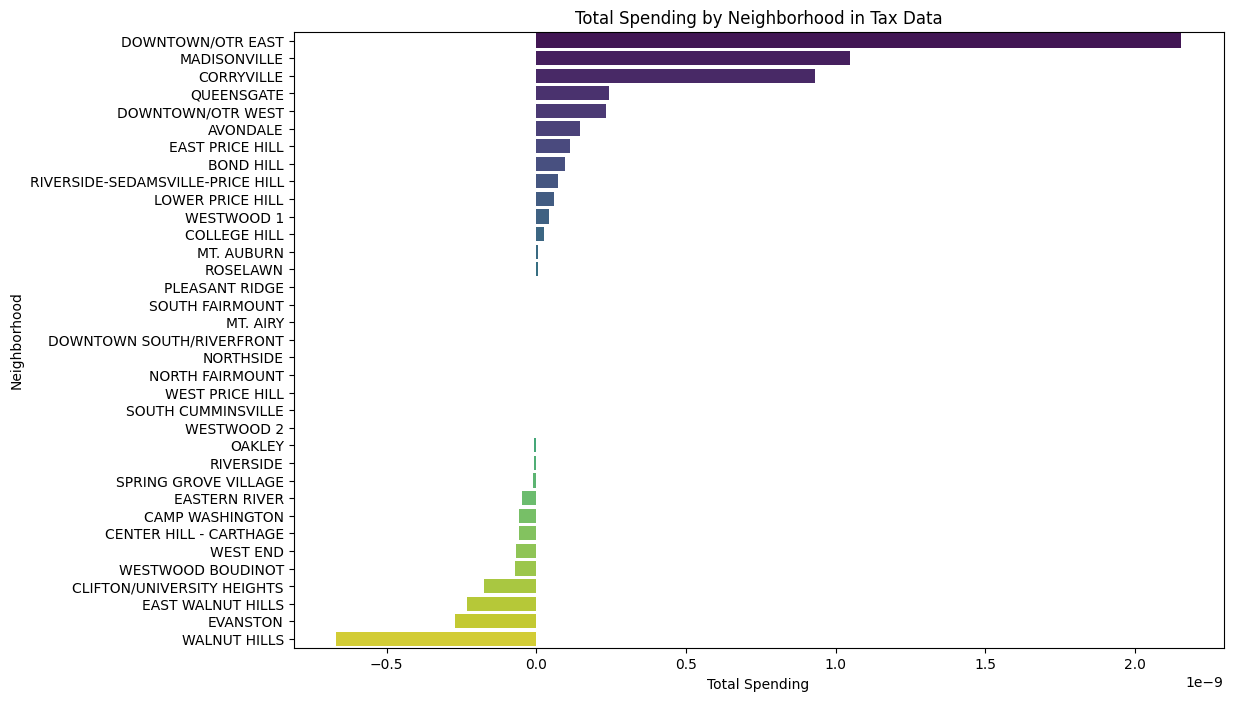

In [21]:
neighborhood_spending = tax_df.groupby('NEIGHBORHOOD')['POSTING_AMOUNT'].sum().reset_index()

neighborhood_spending = neighborhood_spending.sort_values(by='POSTING_AMOUNT', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='POSTING_AMOUNT', y='NEIGHBORHOOD', data=neighborhood_spending, palette='viridis')
plt.title('Total Spending by Neighborhood in Tax Data')
plt.xlabel('Total Spending')
plt.ylabel('Neighborhood')
plt.show()


## Visualization Observations

There were quite a few things that I noticed from the visualizations. 

The first thing is that in the visual of the incidents over time, there were two noticeable uptrends of incidents between 2015-2018 & 2020-2021. However, things appear to be on the downtrend. It is important to consider factors that may have caused those trends, such as more people being at home during 2020-2021 due to covid lockdowns. 

There were no noticeable correlations between data in the tax dataframe besides that with itself and those which it is obviously paired with "budget year and fiscal year" for example. This means that while they may have different amounts spent on each location, it is all generally about the same from a relational standpoint. This can also be seen in the posting amounts as they are generally in one normal distribution. 

Another thing to note that I saw was the hydrant status when broken down by neighborhood seemed to be less favorable for more western neighborhoods. It seems that more of the abandoned hydrants are out that way.

## Machine Learning Plan

Below are some considerations I will be making when developing my machine learning plan.

### Types of Machine Learning:

1. **Regression Analysis:**
   - **Use Case:** Predicting the number of incidents based on economic factors and/or hydrant availability.
   - **Potential Insights:** Understanding the relationship between economic indicators and incident occurrences.

2. **Clustering:**
   - **Use Case:** Grouping neighborhoods based on incident patterns, economic indicators, or hydrant status.
   - **Potential Insights:** Revealing similarities or differences among neighborhoods.

### Issues and Challenges:

1. **Data Quality and Completeness:**
   - **Issue:** Incomplete or inconsistent data across sources may impact model training.
   - **Challenge:** Data cleaning and preprocessing become crucial as handling missing values and outliers is essential for accurate model training.

2. **Feature Selection:**
   - **Issue:** Selecting relevant features from multiple datasets to build effective models.
   - **Challenge:** Identifying the most impactful features and ensuring they align with the problem statement.

3. **Data Integration:**
   - **Issue:** Merging and integrating diverse datasets with varying structures and formats.
   - **Challenge:** Ensuring seamless integration for meaningful analysis and model development.

4. **Imbalanced Datasets:**
   - **Issue:** If certain incident types are rare, imbalanced datasets may impact model performance.
   - **Challenge:** Implementing techniques to handle class imbalance, such as oversampling, undersampling, or using appropriate evaluation metrics.


## Preparation for Machine Learning

In this step I will begin preparing the data and models to be split into sets so that they can be analyzed. 

In [22]:
merged_hydrants_df = pd.merge(fire_incidents_df, hydrant_df, on='NEIGHBORHOOD', how='inner')

In [23]:
X = merged_hydrants_df['active_hydrant_count']
Y = merged_hydrants_df['response_time']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [24]:
x = merged_hydrants_df[['active_hydrant_count']]
y = merged_hydrants_df['response_time']

lin_hydrant_model = LinearRegression()

lin_hydrant_model.fit(x, y)

LinearRegression()

In [ ]:
poly_reg = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_reg.fit(X_train.values.reshape(-1, 1), Y_train)
poly_reg_line_train = poly_reg.predict(X_train.values.reshape(-1, 1))
poly_reg_line_test = poly_reg.predict(X_test.values.reshape(-1, 1))

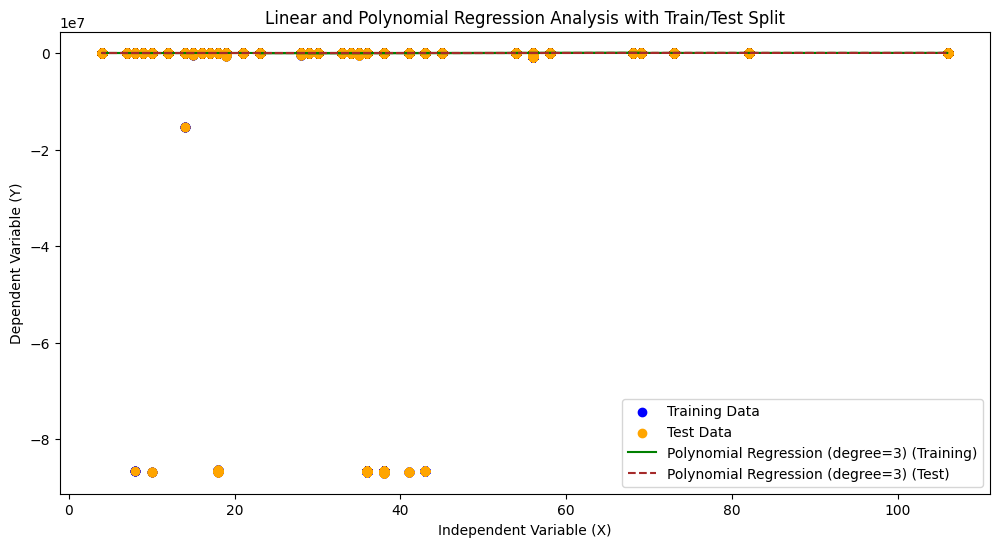

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(X_train, Y_train, label='Training Data', color='blue')

plt.scatter(X_test, Y_test, label='Test Data', color='orange')

plt.plot(X_train, poly_reg_line_train, label='Polynomial Regression (degree=3) (Training)', color='green')
plt.plot(X_test, poly_reg_line_test, label='Polynomial Regression (degree=3) (Test)', linestyle='dashed', color='brown')

plt.title('Linear and Polynomial Regression Analysis with Train/Test Split')
plt.xlabel('Independent Variable (X)')
plt.ylabel('Dependent Variable (Y)')
plt.legend()
plt.show()

## Summary

Ultimately I did not get the items to work on my end. I tried multiple sources and ways of doing this with the pipeline and regression models, but they all turned out like the one above. I am not sure why or how it would be a negative response time number, and no matter what I tried the pipeline and other forms would not work with my information. I do believe there would be a strong correlation between the response time and active hydrants as that would mean the area has more infracstructure set up. 

## Resources and References
*What resources and references have you used for this project?*
📝 <!-- Answer Below -->

All of the data sourced from this project was from [data.cincinnati-oh.gov](https://data.cincinnati-oh.gov/), a project where there is a lot of data about various elements of the greater Cincinnati area.


In [ ]:
# ⚠️ Make sure you run this cell at the end of your notebook before every submission!
!jupyter nbconvert --to python source.ipynb

[NbConvertApp] Converting notebook source.ipynb to python
[NbConvertApp] Writing 20278 bytes to source.py
